<a href="https://colab.research.google.com/github/FrankJRix/lab_util/blob/main/Copia_di_lab_util_provvisorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\begin{table}[H]
\centering
\caption{} %inserire caption
\label{} %inserire label
\begin{tabular}{rll}
\toprule
 $\nu(Hz)$ &        $V_{in} (V)$ &    $V_{out} (V)$ \\
\midrule
        10 &     5.11 $\pm$ 0.56 & 0.345 $\pm$ 0.14 \\
        15 &     4.09 $\pm$ 0.56 & 0.398 $\pm$ 0.14 \\
        20 &     5.08 $\pm$ 0.56 & 0.662 $\pm$ 0.14 \\
        50 &     5.13 $\pm$ 0.56 &  1.56 $\pm$ 0.14 \\
        85 &     2.05 $\pm$ 0.28 & 0.945 $\pm$ 0.14 \\
        95 &     2.05 $\pm$ 0.28 &  1.02 $\pm$ 0.14 \\
       100 &     3.09 $\pm$ 0.56 &  1.59 $\pm$ 0.14 \\
       105 &     2.05 $\pm$ 0.28 &   1.1 $\pm$ 0.14 \\
       107 &     2.05 $\pm$ 0.28 &  1.11 $\pm$ 0.14 \\
       110 &     2.05 $\pm$ 0.28 &  1.13 $\pm$ 0.14 \\
       115 &     2.05 $\pm$ 0.28 &  1.17 $\pm$ 0.14 \\
       150 &     2.04 $\pm$ 0.28 &  1.36 $\pm$ 0.14 \\
       200 &     3.06 $\pm$ 0.28 &  2.33 $\pm$ 0.28 \\
       500 &     2.04 $\pm$ 0.28 &  2.03 $\pm$ 0.28 \\
      1000 &     2.04 $\pm$ 0.28 &  2.44 $\pm$ 0.28 \\

,vin(V),vout,vidiv,vodiv,freq(Hz),err_vin,err_vout,T,err_T
0,5.1100,0.345,2.00,0.5,10,0.5600,0.14,-23.412036,3.650979
1,4.0900,0.398,2.00,0.5,15,0.5600,0.14,-20.236805,3.278635
2,5.0800,0.662,2.00,0.5,20,0.5600,0.14,-17.700114,2.071470
3,5.1300,1.563,2.00,0.5,50,0.5600,0.14,-10.323168,1.226505
4,2.0500,0.945,1.00,0.5,85,0.2800,0.14,-6.726441,1.750232
5,2.0500,1.020,1.00,0.5,95,0.2800,0.14,-6.063074,1.681891
6,3.0900,1.592,2.00,0.5,100,0.5600,0.14,-5.760308,1.749676
7,2.0500,1.100,1.00,0.5,105,0.2800,0.14,-5.407224,1.621586
8,2.0480,1.112,1.00,0.5,107,0.2800,0.14,-5.304503,1.614329
9,2.0480,1.130,1.00,0.5,110,0.2800,0.14,-5.165030,1.602581


filtro pa #1: (170 $\pm$ 31.1)Hz
filtro pa #2: (7.07e+04 $\pm$ 1.23e+04)Hz
filtro pb #3: (1.17e+06 $\pm$ 1.25e+06)Hz


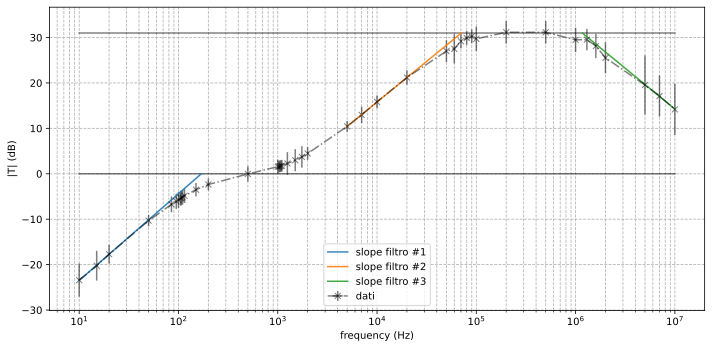

filtro pa #1: (176 $\pm$ 15.8)Hz


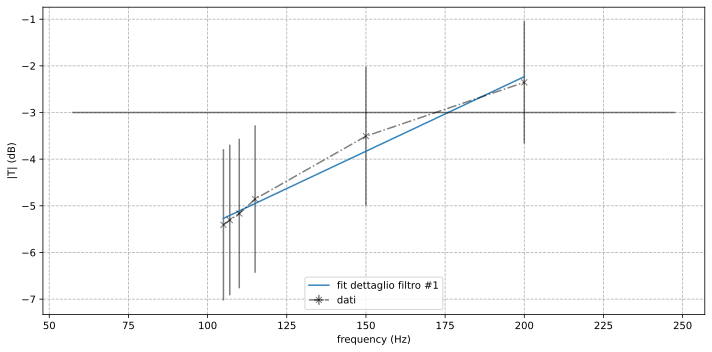

filtro pa #2: (6.01e+04 $\pm$ 1.23e+04)Hz


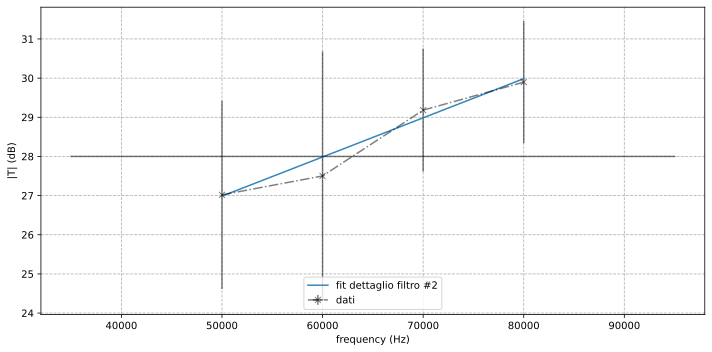

filtro pb #3: (1.55e+06 $\pm$ 4.1e+05)Hz


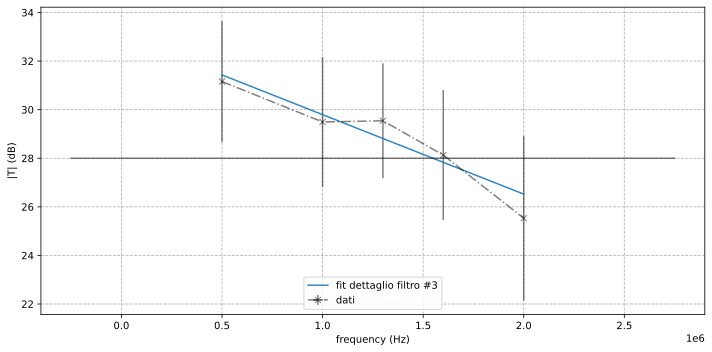

In [ ]:
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import linregress as linfit
from scipy.optimize import curve_fit as cfit

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg') # se su colab, in locale commentata

# la parte sotto va commentata su colab e scommentata in locale su una macchina aggiornata
#import matplotlib_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

fil = 'ce.csv'

# def classi

class Filtro:
  def __init__(self, plat, slope_range, ft_range = [], pa = True, f_t = 0):
    self.f_t = f_t
    self.plat = plat
    self.slope_range = slope_range
    self.ft_range = ft_range
    self.pa = pa

# def funzioni

def errori_osc_volt(valori, div):
    """ si aspetta un array di valori misurati e uno di volt/div come da oscilloscopio
    in output array di errori """
    errors = []

    if len(valori) != len(div):
        print('mismatched input size')
        return
    
    for j in range(len(valori)):
        if div[j] >= 10e-3:
            percent = 0.03
        else:
            percent = 0.04

        scala = div[j]*8
        err = percent*scala + 0.005*scala

        errors.append(err)

        #print(f'{j+1}: ({valori[j]:.3g} +/- {err:.3g})V (scala: {scala}V)')
    
    errors = np.array(errors)
    #print('\n')

    return errors

def errori_osc_tempo(valori, div):
    """ si aspetta un array di valori misurati e uno di s/div come da oscilloscopio """
    errors = []

    if len(valori) != len(div):
        print('mismatched input size')
        return
    
    acc = 50e-6
    off = 200e-12
    factor = 16e-3 #16e-4 * num divisioni orizzontali

    for j in range(len(valori)):
        err = acc*valori[j] + off + factor*div[j]
        
        #print(f'{j+1}: ({valori[j]:.3g} +/- {err:.3g})s')
        errors.append(err)
    
    errors = np.array(errors)
    #print('\n')

    return errors

def leggi_csv(path):
    """ path relativo fino al .csv """
    data = pd.read_csv(path)
    data = data.replace(',','.', regex=True)
    data = data.apply(pd.to_numeric, errors='coerce')
    return data

def compute_phi(dt, err_t, f, err_f = []):
    """ si aspetta quattro (tre) array di valori di dt, errore su dt, frequenza e errore su frequenza (facoltativo)
    in output due array phi e err_phi """
    if len(dt) != len(f):
        print('mismatched input size')
        return
    if len(err_f) == 0:
        err_f = np.zeros(len(f))
    dt = np.array(dt)
    f = np.array(f)
    err_t = np.array(err_t)
    err_f = np.array(err_f)

    conv = 360/(2*np.pi)

    phi = 2*np.pi * f * dt
    phi = conv * phi

    err_phi = conv * np.sqrt((2*np.pi*f*err_t)**2+(2*np.pi*dt*err_f)**2)
    return phi, err_phi

def error_format(val, err):
    """ si aspetta un array di valori e uno di errori 
    in output array di stringhe formattate in latex pronte per tabella"""
    if len(val) != len(err):
        print('mismatched input size')
        return
    out = []
    for i in range(len(val)):
        tmp = f'{val[i]:.3g} $\pm$ {err[i]:.3g}'
        out.append(tmp)
    
    return out

def transf_func(vin, vout, err_vin = [], err_vout = []):
    """ quattro (due) array, V_in, V_out e rispettivi errori (facoltativi)
    output modulo e errore di T """
    vin = np.array(vin)
    vout = np.array(vout)
    if len(err_vin) == 0:
        err_vin = np.zeros(len(vin))
    else:
        err_vin = np.array(err_vin)
    if len(err_vin) == 0:
        err_vout = np.zeros(len(vout))
    else:
        err_vout = np.array(err_vout)

    x = 20 * np.log10(vout/vin)
    err_x = 20*np.sqrt( (err_vout/vout)**2 + (err_vin/vin)**2) / np.log(10)

    return x, err_x

def hor(x, q):
    return q

def fun(x, m, q):
    return m * x + q

def bode_plot(T, f, err_T, err_f = [],  phi = [], err_phi = [], filtri = []):
    """ sei (cinque) array, modulo di T, fase di T, frequenza e rispettivi errori (facoltativo quello su f)
    array di oggetti Filtro per cui calcolare cose
    output grafici e stima di freq taglio """
    if len(err_f) == 0:
        err_f = np.zeros(len(f))
    if len(err_phi) == 0:
        err_phi = np.zeros(len(f))

    t = np.linspace(f.min(), f.max(), 2)

    plt.figure(figsize=(10,5))
    plt.errorbar(f, T, yerr=err_T, xerr=err_f, label='dati', marker='x', linestyle='-.', color='black', alpha = 0.5)

    num = 1
    mem = []
    for filtro in filtri:
        n1 = filtro.slope_range[0]
        n2 = filtro.slope_range[1]
        max = filtro.plat

        if max not in mem:
            plt.plot(t, np.ones(len(t))*max, alpha=0.5, color='black')
            mem.append(max)

        l = np.log(f[n1:n2+1])

        par, cov = cfit(fun, l, T[n1:n2+1], sigma = err_T[n1:n2+1])
        err = np.sqrt(np.diag(cov))

        m = par[0]
        dm = err[0]
        q = par[1]
        dq = err[1]

        ft_pa = np.exp((max-q)/m)
        err_ft_pa = np.sqrt( ((m*dq)**2+(q*dm)**2)*np.exp(2*(max - q)/m) / m**4)
        
        if filtro.pa:
            t_pa = np.linspace(f[n1], ft_pa, 2)
            l_pa = np.log(t_pa)
            print(f'filtro pa #{num}: ({ft_pa:.3g} $\pm$ {err_ft_pa:.3g})Hz')
        else:
            t_pa = np.linspace(ft_pa, f[n2], 2)
            l_pa = np.log(t_pa) 
            print(f'filtro pb #{num}: ({ft_pa:.3g} $\pm$ {err_ft_pa:.3g})Hz')           

        plt.plot(t_pa, m*l_pa + q, label=f'slope filtro #{num}', alpha = 0.9)
        num += 1

    plt.semilogx()
    plt.xlabel('frequency (Hz)')
    plt.ylabel('|T| (dB)')
    plt.grid(True, 'both', linestyle='--')

    plt.legend(loc='lower center')

    plt.tight_layout()
    plt.savefig("bode_T.pdf", bbox_inches='tight')
    plt.show()

    if len(phi) > 0:
        plt.figure(figsize=(10,5))
        plt.errorbar(f, phi, yerr=err_phi, xerr=err_f, label='dati', marker='.', linestyle='-.', alpha = 0.5, color='black')
        plt.semilogx()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('$d\phi$ (deg)')
        

        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig("bode_phi.pdf", bbox_inches='tight')
        plt.show()
    
    num = 1
    for filtro in filtri:
        if len(filtro.ft_range) > 0:
            n1 = filtro.ft_range[0]
            n2 = filtro.ft_range[1]

            max = filtro.plat
            T_3 = max - 3

            mean = (f[n2]-f[n1]) / 2
            t = np.linspace(f[n1] - mean, f[n2] + mean, 2)

            l = f[n1:n2+1]

            par, cov = cfit(fun, l, T[n1:n2+1], sigma = err_T[n1:n2+1])
            err = np.sqrt(np.diag(cov))

            m = par[0]
            dm = err[0]
            q = par[1]
            dq = err[1]

            ft_pa = (T_3-q)/m
            err_ft_pa = np.sqrt( ((m*dq)**2+(T_3-q)**2*dm**2) / m**4)

            if filtro.pa:
                t_pa = np.linspace(f[n1], f[n2], 2)
                print(f'filtro pa #{num}: ({ft_pa:.3g} $\pm$ {err_ft_pa:.3g})Hz')
            else:
                t_pa = np.linspace(f[n1], f[n2], 2)
                print(f'filtro pb #{num}: ({ft_pa:.3g} $\pm$ {err_ft_pa:.3g})Hz')           

            plt.figure(figsize=(10,5))

            plt.errorbar(f[n1:n2+1], T[n1:n2+1], yerr=err_T[n1:n2+1], xerr=err_f[n1:n2+1], label='dati', marker='x', linestyle='-.', color='black', alpha = 0.5)
            plt.plot(t_pa, m*t_pa + q, label=f'fit dettaglio filtro #{num}', alpha = 0.9)
            plt.plot(t, np.ones(len(t))*T_3, alpha=0.5, color='black')

            plt.xlabel('frequency (Hz)')
            plt.ylabel('|T| (dB)')
            plt.grid(True, 'both', linestyle='--')

            plt.legend(loc='lower center')
            plt.tight_layout()
            plt.savefig(f"bode_dettaglio_filtro#{num}.pdf", bbox_inches='tight')
            plt.show()
            num += 1

def analisi_risposta(path, filtri, has_dt = False):
    """ path: path al .csv
    filtri : array oggetti filtro
    has_dt: True se c'è l'analisi di phi, default False """
    data = leggi_csv(path)
    tab_misure = pd.DataFrame()
    tab_analisi = pd.DataFrame()
    
    tab_misure.insert(len(tab_misure.columns), '$\nu(Hz)$', data['freq(Hz)'])
    tab_analisi.insert(len(tab_analisi.columns), '$\nu(Hz)$', data['freq(Hz)'])

    err_vi = errori_osc_volt(data['vin(V)'], data['vidiv'])
    err_vo = errori_osc_volt(data['vout'], data['vodiv'])
    data.insert(len(data.columns), 'err_vin', err_vi)
    data.insert(len(data.columns), 'err_vout', err_vo)

    m_vin =  error_format(data['vin(V)'], data['err_vin'])
    m_vout =  error_format(data['vout'], data['err_vout'])

    T, err_T = transf_func(data['vin(V)'], data['vout'], data['err_vin'], data['err_vout'])
    data.insert(len(data.columns), 'T', T)
    data.insert(len(data.columns), 'err_T', err_T)

    a_T = error_format(T, err_T)

    tab_misure.insert(len(tab_misure.columns), '$V_{in} (V)$', m_vin)
    tab_misure.insert(len(tab_misure.columns), '$V_{out} (V)$', m_vout)
    
    tab_analisi.insert(len(tab_analisi.columns), '$|T| (dB)$', a_T)
    
    if has_dt:
        err_dt = errori_osc_tempo(data['dt(s)'], data['tdiv'])
        data.insert(len(data.columns), 'err_dt', err_dt)

        m_dt = error_format(data['dt(s)'], err_dt)
        tab_misure.insert(len(tab_misure.columns), '$dt (s)$', m_dt)

        phi , err_phi = compute_phi(data['dt(s)'], data['err_dt'], data['freq(Hz'])
        data.insert(len(data.columns), 'phi', phi)
        data.insert(len(data.columns), 'err_phi', err_phi)

        a_phi = error_format(phi, err_phi)
        tab_analisi.insert(len(tab_analisi.columns), '$\phi (deg)$', phi)
    
    print(r'\begin{table}[H]')
    print(r'\centering')
    print(r'\caption{} %inserire caption')
    print(r'\label{} %inserire label')
    tab_misure = tab_misure.to_latex(escape=False, index=False)
    print(tab_misure)
    print(r'\end{table}')
    print('\n\n')

    print(r'\begin{table}[H]')
    print(r'\centering')
    print(r'\caption{} %inserire caption')
    print(r'\label{} %inserire label')
    tab_analisi = tab_analisi.to_latex(escape=False, index=False)
    print(tab_analisi)
    print(r'\end{table}')
    print('\n\n')

    display(data)
    bode_plot(data['T'], data['freq(Hz)'], data['err_T'], filtri = filtri)

#playground

#esempio finale

#filtri finti
# slope_pa1 = (0,3)
# ft1_range = (4,7)
# pa1 = Filtro(75, 32, slope_pa1, ft_range = ft1_range, pa = True)

# slope_pa2 = (14,17)
# ft2_range = (18,21)
# pa2 = Filtro(36.3, slope_pa2, ft_range = ft2_range, pa = True)

# slope_pb3 = (33,36)
# ft3_range = (28,31)
# pb3 = Filtro(36.3, slope_pb3, ft_range = ft3_range, pa = False)

#filtri ES2
slope_pa1 = (0,2)
ft1_range = (7,12)
pa1 = Filtro(0, slope_pa1, ft_range = ft1_range, pa = True)

slope_pa2 = (23,25)
ft2_range = (27,30)
pa2 = Filtro(31, slope_pa2, ft_range = ft2_range, pa = True)

slope_pb3 = (39,41)
ft3_range = (34,38)
pb3 = Filtro(31, slope_pb3, ft_range = ft3_range, pa = False)

filtri = [pa1, pa2, pb3]

analisi_risposta(fil, filtri)